In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [2]:
IMG_PATH = "data/Medical Mask/images"

In [3]:
# Load model
model = load_model('models/facemask_detector_model.keras')

# Model Summary
# model.summary()

In [4]:
def get_image_path(image_name):
    return os.path.join(IMG_PATH, image_name)

def get_roi(img, roi_size, xmin, ymin, xmax, ymax):
    roi = img[ymin:ymax, xmin:xmax]
    roi = cv2.resize(roi, roi_size)
    return cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

In [5]:
train = pd.read_csv("fixed_train.csv")
test = pd.read_csv("submission.csv")
final = pd.DataFrame(columns=test.columns)
display(train.head(),test.head())

,name,x1,y1,x2,y2,classname
0,2756.png,69,126,294,392,1
1,2756.png,505,10,723,283,1
2,6098.jpg,360,85,728,653,0
3,6427.png,278,386,582,582,1
4,4591.png,239,9,522,342,1


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


Approach for every unique image name detect faces and make a new row for every face identified

In [6]:
# Does not work with side faces
face_cascade = cv2.CascadeClassifier('cv/haarcascade_frontalface_default.xml')

# Still isn't great with face detection but better than haarcascade
# Was taking more than 20min to detect faces in test def wont work with 2nd task 
face_detector = MTCNN()

def detect_faces(frame):
    # Convert frame to RGB (MTCNN requires RGB format)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect faces in the frame
    detections = face_detector.detect_faces(rgb_frame)
    
    # Extract bounding boxes from the detections
    face_bboxes = [(d['box'][0], d['box'][1], d['box'][0] + d['box'][2], d['box'][1] + d['box'][3])
                   for d in detections]
    
    return face_bboxes

In [7]:
# caffemodel faster than mtcnn similar detection
# todo try dlib too

modelFile = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "face_detector/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def dnn_detect_faces(frame):
    h,w = frame.shape[:2]
    # blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 117.0, 123.0))
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0,(300, 300), (104.0, 117.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    faces_bboxes = []
    # Loop over the detections and draw bounding boxes
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # Filter out weak detections
        if confidence > 0.3:
            # Get the coordinates of the bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            faces_bboxes.append((x1, y1, x2, y2))

    return faces_bboxes

In [15]:
x = train.iloc[4]
img = cv2.imread(get_image_path(x["name"]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
0.9786308


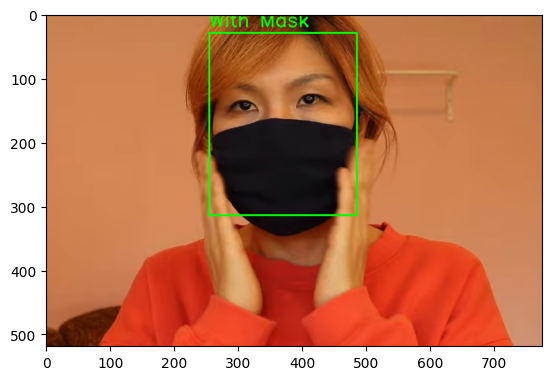

In [16]:
faces = dnn_detect_faces(img)
for (x1, y1, x2, y2) in faces:
    face_roi = img[y1:y2, x1:x2]
    face_resized = cv2.resize(face_roi, (100, 100))
    face_resized = np.reshape(face_resized, (1,100,100,3))

    prediction = model.predict(face_resized)
    print(prediction[0][0])

    if prediction[0][0] > 0.5:
        predicted_class = "With Mask"
    else:
        predicted_class = "No Mask"

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{predicted_class}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

if len(faces) == 0:
    print("No Faces")

plt.imshow(img)

In [10]:
unique_image_names = test["name"].unique()

In [11]:
# roi_size = (100,100)
for name in unique_image_names:
    print("Processing Image: ", name)
    try:
        img = cv2.imread(get_image_path(name))
        # Check if the image was loaded
        if img is None:
            print("Error Image not found")
            raise ValueError(
                f"Image not found at {os.path.join(IMG_PATH, name)}"
            )
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Get faces b_boxes
        faces = dnn_detect_faces(img)
        print(f"Detected: {len(faces)} faces in the image: {name}")

        new_rows = []

        if len(faces)==0:
            new_row = {
                "name": name,
                "x1": 0,
                "x2": 0,
                "y1": 0,
                "y2": 0,
                "classname": "blank"
            }
            new_rows.append(new_row)


        for (x1, y1, x2, y2) in faces:
            face_roi = img[y1:y2, x1:x2]
            face_resized = cv2.resize(face_roi, (100, 100))
            face_resized = np.reshape(face_resized, (1,100,100,3))

            prediction = model.predict(face_resized)

            if prediction[0][0] > 0.5:
                predicted_class = "face_with_mask"
            else:
                predicted_class = "face_no_mask"
            
            new_row = {
                "name": name,
                "x1": x1,
                "x2": x2,
                "y1": y1,
                "y2": y2,
                "classname": predicted_class
            }
            new_rows.append(new_row)
        
        final = pd.concat([final, pd.DataFrame(new_rows)], ignore_index=True)

    except Exception as e: 
        print(e)
        new_row = {
            "name": name,
            "x1": 0,
            "x2": 0,
            "y1": 0,
            "y2": 0,
            "classname": "missing"
        }
        new_rows.append(new_row)

Processing Image:  1800.jpg
Detected: 0 faces in the image: 1800.jpg
Processing Image:  1799.jpg
Detected: 0 faces in the image: 1799.jpg
Processing Image:  1797.jpg
Detected: 1 faces in the image: 1797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing Image:  1796.jpg
Detected: 2 faces in the image: 1796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processing Image:  1795.jpg
Detected: 4 faces in the image: 1795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing Image:  1794.jpg
Detected: 1 faces in the image: 1794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Processing Image:  1793.jpg
Detected: 1 faces in the image: 1793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing Image:  1792.jpeg
Detected: 2 faces in the image: 1792.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing Image:  1791.jpg


In [12]:
final.head()

,name,x1,x2,y1,y2,classname
0,1800.jpg,0,0,0,0,blank
1,1799.jpg,0,0,0,0,blank
2,1797.jpg,789,1211,262,902,face_with_mask
3,1796.jpg,930,1167,207,522,face_with_mask
4,1796.jpg,476,675,222,465,face_with_mask


In [13]:
final["classname"].value_counts()

classname
face_with_mask    1304
blank              524
face_no_mask       275
Name: count, dtype: int64

In [14]:
final.to_csv("final_submission.csv")